<a href="https://colab.research.google.com/github/sailorcosmos101/3D-PINN-for-GW/blob/main/3D-PINN-forGW-SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap, jacfwd, jacrev
import optax
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import cm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# Define the 3D domain
xmin, xmax = 0.0, 1.0  # X-boundary
ymin, ymax = 0.0, 1.0  # Y-boundary
zmin, zmax = 0.0, 1.0  # Z-boundary

In [6]:
N_b = 200  # Increase number of boundary points per boundary condition points
N_r = 10000  # Increase number of collocation points within the domain

# Define the boundary conditons
h1 = 10
h2 = 1
dh_dall = 0

In [7]:
# Define hydraulic conductivity function
def hydraulic_conductivity(x, y, z):
    """
    Define piecewise hydraulic conductivity K.
    """
    K = 0.5
    return K

In [8]:
def generate_BCs_and_colloc(N_b, N_r, xmin, xmax, ymin, ymax, zmin, zmax, h1, h2, dh_dall):
    """
    Generates boundary conditions and collocation points.

    Parameters:
    - N_b: Number of boundary condition points.
    - N_r: Number of collocation points.
    - ymin, ymax: Minimum and maximum values for y.
    - xmin, xmax: Minimum and maximum values for x.
    - zmin, zmax: Minimum and maximum values for z.
    - left_bc: Boundary condition value at x=0.
    - right_bc: Boundary condition value at x=1.

    Returns:
    - conds: A list of arrays for each boundary condition.
    - colloc: An array of collocation points.
    """
    # Generate random number generator keys
    bk1, bk2, bk3, bk4, bk5, bk6, r1k, r2k, r3k = jax.random.split(jax.random.PRNGKey(0), 9)

    # Left BC (Face 1): h[0, y, z] = 1
    y_b1 = jax.random.uniform(bk1, minval=ymin, maxval=ymax, shape=(N_b, 1))
    z_b1 = jax.random.uniform(bk1, minval=zmin, maxval=zmax, shape=(N_b, 1))
    x_b1 = jnp.full_like(y_b1, xmin)  # x = 0
    bc_1 = jnp.ones_like(y_b1) * h1  # h = 1 at x=0
    BC_1 = jnp.concatenate([x_b1, y_b1, z_b1, bc_1], axis=1)

    # Face 2: dh/dy[x, 1, z] = 0
    x_b2 = jax.random.uniform(bk2, minval=xmin, maxval=zmax, shape=(N_b, 1))
    z_b2 = jax.random.uniform(bk2, minval=zmin, maxval=zmax, shape=(N_b, 1))
    y_b2 = jnp.full_like(x_b2, ymax)   # y = 1
    bc_2 = jnp.ones_like(x_b2) * dh_dall  # dh/dy = 0
    BC_2 = jnp.concatenate([x_b2, y_b2, z_b2, bc_2], axis=1)

    # Right BC (Face 3): h[1, y, z] = 0.5
    y_b3 = jax.random.uniform(bk3, minval=ymin, maxval=ymax, shape=(N_b, 1))
    z_b3 = jax.random.uniform(bk3, minval=zmin, maxval=zmax, shape=(N_b, 1))
    x_b3 = jnp.full_like(y_b3, xmax)  # x = 1
    bc_3 = jnp.ones_like(y_b3) * h2  # h = 0.5 at x=1
    BC_3 = jnp.concatenate([x_b3, y_b3, z_b3, bc_3], axis=1)

    # Face 4: dh/dy[x, 0, z] = 0
    x_b4 = jax.random.uniform(bk4, minval=xmin, maxval=ymax, shape=(N_b, 1))
    z_b4 = jax.random.uniform(bk4, minval=zmin, maxval=zmax, shape=(N_b, 1))
    y_b4 = jnp.full_like(x_b4, ymin)  # y = 0
    bc_4 = jnp.ones_like(x_b4) * dh_dall  # dh/dy = 0
    BC_4 = jnp.concatenate([x_b4, y_b4, z_b4, bc_4], axis=1)

    # Face 5: dh/dz[x, y, 1] = 0
    x_b5 = jax.random.uniform(bk5, minval=xmin, maxval=ymax, shape=(N_b, 1))
    y_b5 = jax.random.uniform(bk5, minval=ymin, maxval=ymax, shape=(N_b, 1))
    z_b5 = jnp.full_like(x_b5, zmax)  # z = 1
    bc_5 = jnp.ones_like(y_b5) * dh_dall  # dh/dz = 0
    BC_5 = jnp.concatenate([x_b5, y_b5, z_b5, bc_5], axis=1)

    # Face 6: dh/dz[x, y, 0] = 0
    x_b6 = jax.random.uniform(bk6, minval=xmin, maxval=ymax, shape=(N_b, 1))
    y_b6 = jax.random.uniform(bk6, minval=ymin, maxval=ymax, shape=(N_b, 1))
    z_b6 = jnp.full_like(x_b6, zmin)  # z = 0
    bc_6 = jnp.ones_like(y_b6) * dh_dall  # dh/dz = 0
    BC_6 = jnp.concatenate([x_b6, y_b6, z_b6, bc_6], axis=1)

    conds = [BC_1, BC_2, BC_3, BC_4, BC_5, BC_6]

    # Collocation points
    x_c = jax.random.uniform(r1k, minval=xmin, maxval=xmax, shape=(N_r, 1))
    y_c = jax.random.uniform(r2k, minval=ymin, maxval=ymax, shape=(N_r, 1))
    z_c = jax.random.uniform(r3k, minval=zmin, maxval=zmax, shape=(N_r, 1))
    colloc = jnp.concatenate([x_c, y_c, z_c], axis=1)

    return x_b1, y_b1, z_b1, bc_1, x_b2, y_b2, z_b2, bc_2, x_b3, y_b3, z_b3, bc_3, x_b4, y_b4, z_b4, bc_4, x_b5, y_b5, z_b5, bc_5, x_b6, y_b6, z_b6, bc_6, x_c, y_c, z_c, conds, colloc

x_b1, y_b1, z_b1, bc_1, x_b2, y_b2, z_b2, bc_2, x_b3, y_b3, z_b3, bc_3, x_b4, y_b4, z_b4, bc_4, x_b5, y_b5, z_b5, bc_5, x_b6, y_b6, z_b6, bc_6, x_c, y_c, z_c, conds, colloc = generate_BCs_and_colloc(N_b, N_r, xmin, xmax, ymin, ymax, zmin, zmax, h1, h2, dh_dall)

In [9]:
def generate_BCs_and_colloc(N_b, N_r, xmin, xmax, ymin, ymax, zmin, zmax, h1, h2, dh_dall):
    bk1, bk2, bk3, bk4, bk5, bk6, r1k, r2k, r3k = jax.random.split(jax.random.PRNGKey(0), 9)

    # 균일한 격자로 Left BC (Face 1) 생성
    y_linspace = jnp.linspace(ymin, ymax, int(jnp.sqrt(N_b)))
    z_linspace = jnp.linspace(zmin, zmax, int(jnp.sqrt(N_b)))
    Y_mesh, Z_mesh = jnp.meshgrid(y_linspace, z_linspace)
    y_b1 = Y_mesh.ravel().reshape(-1, 1)
    z_b1 = Z_mesh.ravel().reshape(-1, 1)
    x_b1 = jnp.full_like(y_b1, xmin)  # x = 0
    bc_1 = jnp.ones_like(y_b1) * h1
    BC_1 = jnp.concatenate([x_b1, y_b1, z_b1, bc_1], axis=1)

    # Right BC (Face 3)도 동일하게 생성
    Y_mesh, Z_mesh = jnp.meshgrid(y_linspace, z_linspace)
    y_b3 = Y_mesh.ravel().reshape(-1, 1)
    z_b3 = Z_mesh.ravel().reshape(-1, 1)
    x_b3 = jnp.full_like(y_b3, xmax)  # x = 1
    bc_3 = jnp.ones_like(y_b3) * h2
    BC_3 = jnp.concatenate([x_b3, y_b3, z_b3, bc_3], axis=1)

    # Face 2 & 4 (y = 0 또는 y = 1) 격자로 생성
    X_mesh, Z_mesh = jnp.meshgrid(jnp.linspace(xmin, xmax, int(jnp.sqrt(N_b))), z_linspace)
    x_b2, z_b2 = X_mesh.ravel().reshape(-1, 1), Z_mesh.ravel().reshape(-1, 1)
    y_b2 = jnp.full_like(x_b2, ymax)  # y = 1
    bc_2 = jnp.ones_like(x_b2) * dh_dall
    BC_2 = jnp.concatenate([x_b2, y_b2, z_b2, bc_2], axis=1)

    x_b4, z_b4 = X_mesh.ravel().reshape(-1, 1), Z_mesh.ravel().reshape(-1, 1)
    y_b4 = jnp.full_like(x_b4, ymin)  # y = 0
    bc_4 = jnp.ones_like(x_b4) * dh_dall
    BC_4 = jnp.concatenate([x_b4, y_b4, z_b4, bc_4], axis=1)

    # Face 5 & 6 (z = 0 또는 z = 1) 격자로 생성
    X_mesh, Y_mesh = jnp.meshgrid(jnp.linspace(xmin, xmax, int(jnp.sqrt(N_b))), y_linspace)
    x_b5, y_b5 = X_mesh.ravel().reshape(-1, 1), Y_mesh.ravel().reshape(-1, 1)
    z_b5 = jnp.full_like(x_b5, zmax)  # z = 1
    bc_5 = jnp.ones_like(x_b5) * dh_dall
    BC_5 = jnp.concatenate([x_b5, y_b5, z_b5, bc_5], axis=1)

    x_b6, y_b6 = X_mesh.ravel().reshape(-1, 1), Y_mesh.ravel().reshape(-1, 1)
    z_b6 = jnp.full_like(x_b6, zmin)  # z = 0
    bc_6 = jnp.ones_like(x_b6) * dh_dall
    BC_6 = jnp.concatenate([x_b6, y_b6, z_b6, bc_6], axis=1)

    conds = [BC_1, BC_2, BC_3, BC_4, BC_5, BC_6]

    return x_b1, y_b1, z_b1, bc_1, x_b2, y_b2, z_b2, bc_2, x_b3, y_b3, z_b3, bc_3, x_b4, y_b4, z_b4, bc_4, x_b5, y_b5, z_b5, bc_5, x_b6, y_b6, z_b6, bc_6, x_c, y_c, z_c, conds, colloc

x_b1, y_b1, z_b1, bc_1, x_b2, y_b2, z_b2, bc_2, x_b3, y_b3, z_b3, bc_3, x_b4, y_b4, z_b4, bc_4, x_b5, y_b5, z_b5, bc_5, x_b6, y_b6, z_b6, bc_6, x_c, y_c, z_c, conds, colloc = generate_BCs_and_colloc(N_b, N_r, xmin, xmax, ymin, ymax, zmin, zmax, h1, h2, dh_dall)


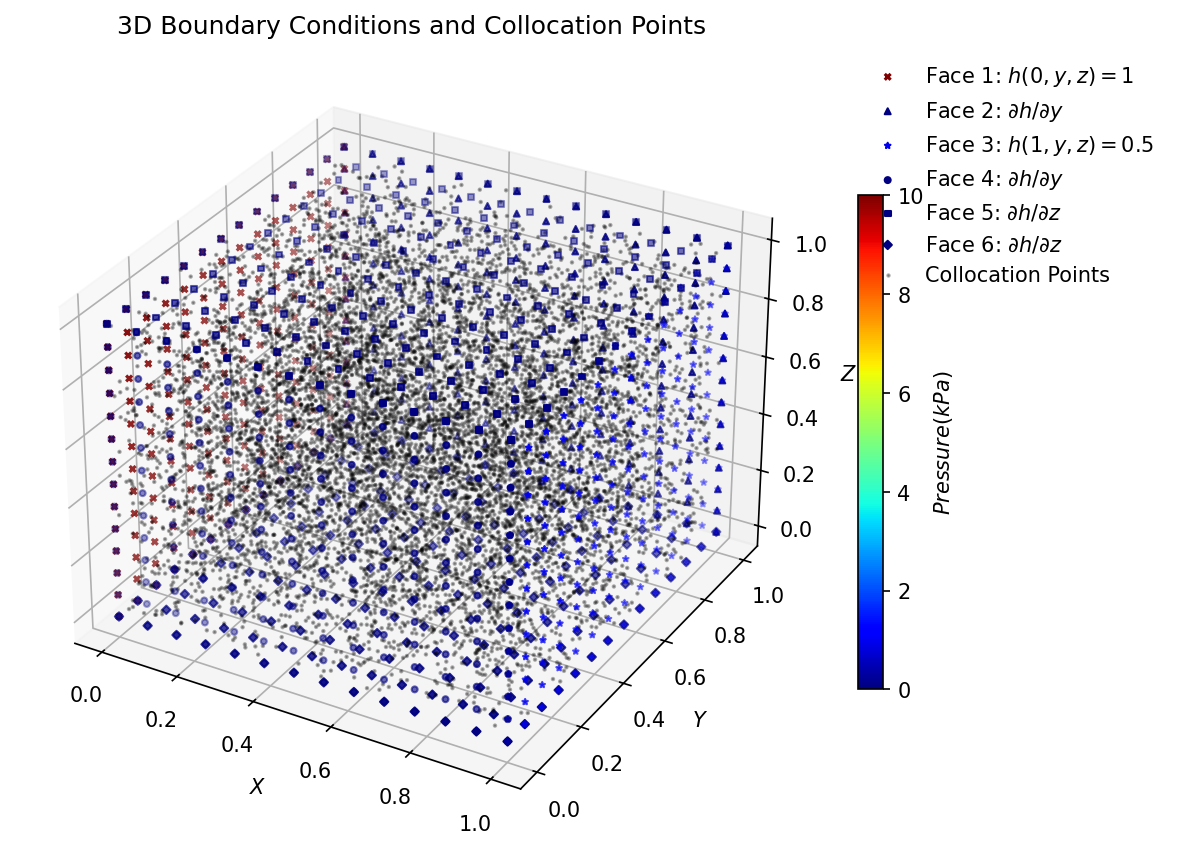

In [10]:
def plot_3D_boundary_conditions(x_b1, y_b1, z_b1, bc_1,
                                 x_b2, y_b2, z_b2, bc_2,
                                 x_b3, y_b3, z_b3, bc_3,
                                 x_b4, y_b4, z_b4, bc_4,
                                 x_b5, y_b5, z_b5, bc_5,
                                 x_b6, y_b6, z_b6, bc_6,
                                 x_c, y_c, z_c):
    fig = plt.figure(figsize=(8, 6), dpi=150)
    ax = fig.add_subplot(111, projection='3d')

    # Calculate vmin and vmax based on all boundary condition values
    all_bc_values = jnp.concatenate([bc_1, bc_2, bc_3, bc_4, bc_5, bc_6])
    vmin, vmax = all_bc_values.min(), all_bc_values.max()

    # Scatter plot settings
    s = 8  # Point size
    alpha = 0.8  # Transparency

    # Plot each boundary condition with a different marker
    scatter1 = ax.scatter(x_b1, y_b1, z_b1, c=bc_1, marker='x', cmap=cm.jet, vmin=vmin, vmax=vmax, s=s, label='Face 1: $h(0,y,z)=1$')
    ax.scatter(x_b2, y_b2, z_b2, c=bc_2, marker='^', cmap=cm.jet, vmin=vmin, vmax=vmax, s=s, label='Face 2: $\partial h / \partial y$')
    ax.scatter(x_b3, y_b3, z_b3, c=bc_3, marker='*', cmap=cm.jet, vmin=vmin, vmax=vmax, s=s, label='Face 3: $h(1,y,z)=0.5$')
    ax.scatter(x_b4, y_b4, z_b4, c=bc_4, marker='o', cmap=cm.jet, vmin=vmin, vmax=vmax, s=s, label='Face 4: $\partial h / \partial y$')
    ax.scatter(x_b5, y_b5, z_b5, c=bc_5, marker='s', cmap=cm.jet, vmin=vmin, vmax=vmax, s=s, label='Face 5: $\partial h / \partial z$')
    ax.scatter(x_b6, y_b6, z_b6, c=bc_6, marker='D', cmap=cm.jet, vmin=vmin, vmax=vmax, s=s, label='Face 6: $\partial h / \partial z$')

    # Plot collocation points (small black dots)
    ax.scatter(x_c, y_c, z_c, c='k', marker='.', alpha=0.3, s=5, label='Collocation Points')

    # Labels and title
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.set_title('3D Boundary Conditions and Collocation Points')

    # Colorbar
    cbar = fig.colorbar(scatter1, ax=ax, shrink=0.6, aspect=20)
    cbar.set_label('$Pressure (kPa)$')

    # Legend
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

    plt.tight_layout()
    plt.show()

# Call the function to visualize the 3D boundary conditions
plot_3D_boundary_conditions(x_b1, y_b1, z_b1, bc_1,
                            x_b2, y_b2, z_b2, bc_2,
                            x_b3, y_b3, z_b3, bc_3,
                            x_b4, y_b4, z_b4, bc_4,
                            x_b5, y_b5, z_b5, bc_5,
                            x_b6, y_b6, z_b6, bc_6,
                            x_c, y_c, z_c)

In [11]:
# Define 3D Darcy Flow PDE Residual
def pde_residual_3d_darcy(xyz, h):
    """
    Compute the PDE residual for 3D Darcy's groundwater flow in heterogeneous media.

    Args:
        h: Lambda function representing the neural network solution h(x, y, z).
        xyz: Collocation points (array of shape Nx3).

    Returns:
        pde_res: PDE residual (array of shape Nx1).
    """
    xyz = xyz.reshape(-1, 3)
    x, y, z = xyz[:, 0:1], xyz[:, 1:2], xyz[:, 2:3]

    # K = hydraulic_conductivity(x, y, z)
    K_constant = 0.7

    h_grad = vmap(jacfwd(h))(xyz)  # First-order derivatives (N, 3)

    h_x, h_y, h_z = h_grad[:, 0], h_grad[:, 1], h_grad[:, 2]
    # q_x, q_y, q_z = K(x, y, z)*h_x, K(x, y, z)*h_y, K(x, y, z)*h_z
    q_x, q_y, q_z = -K_constant*h_x, -K_constant*h_y, -K_constant*h_z

    div_q = vmap(lambda xyz: jnp.sum)

    # Compute divergence of flux (∇·q)
    """
    div_q = vmap(lambda xyz: jnp.sum(jacrev(lambda xyz: jnp.array([
        K(xyz[0], xyz[1], xyz[2]) * jacfwd(h)(xyz)[0],  # d/dx(K * dh/dx)
        K(xyz[0], xyz[1], xyz[2]) * jacfwd(h)(xyz)[1],  # d/dy(K * dh/dy)
        K(xyz[0], xyz[1], xyz[2]) * jacfwd(h)(xyz)[2]   # d/dz(K * dh/dz)
    ]))(xyz)))(xyz)
    """
    div_q = vmap(lambda xyz: jnp.sum(jacrev(lambda xyz: jnp.array([
        -K_constant * jacfwd(h)(xyz)[0],  # d/dx(K * dh/dx)
        -K_constant * jacfwd(h)(xyz)[1],  # d/dy(K * dh/dy)
        -K_constant * jacfwd(h)(xyz)[2]   # d/dz(K * dh/dz)
    ]))(xyz)))(xyz)

    pde_res = div_q.reshape(-1, 1)
    return pde_res

In [12]:
# Generate 3D grid for visualization
nx, ny, nz = 20, 20, 20
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
z = np.linspace(zmin, zmax, nz)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
xyz_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T  # Shape (nx*ny*nz, 3)

In [13]:
# Define the Neural Network Architecture
def neural_net(params, xyz):
    """
    Forward pass through the neural network.
    """
    for w, b in params:
        h_nn = jnp.dot(xyz, w) + b
        xyz = jnp.tanh(h_nn)  # Activation function
    return h_nn.reshape(-1, 1)

In [14]:
def init_mlp(layers, key):
    """
    Initialize the neural network using Xavier initialization.

    Args:
        layers: List defining the number of nodes in each layer (e.g., [1, 50, 50, 1]).
        key: Random key for initialization.

    Returns:
        params: Initialized weights and biases for the network.
    """
    params = []
    for i in range(len(layers) - 1):
        key, subkey = random.split(key)
        bound = jnp.sqrt(6. / (layers[i] + layers[i+1]))
        weights = random.uniform(subkey, (layers[i], layers[i+1]), minval=-bound, maxval=bound)
        biases = jnp.zeros(layers[i+1])
        params.append((weights, biases))
    return params

In [15]:
def loss_func(params, colloc, conds, colloc_h_init):
    """
    Computes the total loss for the 3D Darcy PINN model with Face-specific boundary conditions.

    Inputs:
        params: Neural network parameters.
        colloc: Collocation points (N x 3).
        conds: List of boundary conditions (Dirichlet & Neumann BCs).

    Output:
        Scalar loss value.
    """
    x_c, y_c, z_c = colloc[:, [0]], colloc[:, [1]], colloc[:, [2]]

    # Neural network function for head h(x, y, z)
    h = lambda xyz: neural_net(params, xyz)

    # 1. PDE Residual Loss
    pde_loss = jnp.mean(pde_residual_3d_darcy(colloc, h)**2)

    # 2. Dirichlet BC Loss (Face 1 & Face 3)
    dbc_loss = 0
    for cond in [conds[0], conds[2]]:  # Face 1 (x=0), Face 3 (x=1)
        x_b, y_b, z_b, h_b = cond[:, [0]], cond[:, [1]], cond[:, [2]], cond[:, [3]]
        dbc_loss += jnp.mean((h(x_b, y_b, z_b) - h_b) ** 2)

    # 3. Neumann BC Loss (Face 2, 4, 5, 6)
    nbc_loss = 0

    # 미분 연산을 위한 자동 미분 함수
    dh_dy = lambda xyz: jax.grad(h, argnums=1)(xyz)
    dh_dz = lambda xyz: jax.grad(h, argnums=2)(xyz)

    # Face 2 (y=ymax) & Face 4 (y=ymin) → dh/dy = 0
    for cond in [conds[1], conds[3]]:
        x_b, y_b, z_b, grad_b = cond[:, [0]], cond[:, [1]], cond[:, [2]], cond[:, [3]]
        nbc_loss += jnp.mean((dh_dy(x_b, y_b, z_b) - grad_b) ** 2)

    # Face 5 (z=zmax) & Face 6 (z=zmin) → dh/dz = 0
    for cond in [conds[4], conds[5]]:
        x_b, y_b, z_b, grad_b = cond[:, [0]], cond[:, [1]], cond[:, [2]], cond[:, [3]]
        nbc_loss += jnp.mean((dh_dz(x_b, y_b, z_b) - grad_b) ** 2)

    # 추가된 물리적 제약 (Soft Constraint)
    min_violation = jnp.mean(jnp.maximum(0, -h(colloc).squeeze()) ** 2)  # h < 0일 때 패널티

    loss = pde_loss + dbc_loss + nbc_loss + min_violation

    return jnp.sum(loss)  # Return scalar loss

In [16]:
def loss_func(params, colloc, conds, colloc_h_init):
    """
    Computes the total loss for the 3D Darcy PINN model with Face-specific boundary conditions.

    Inputs:
        params: Neural network parameters.
        colloc: Collocation points (N x 3).
        conds: List of boundary conditions (Dirichlet & Neumann BCs).
        colloc_h_init: Initial pressure values for collocation points.

    Output:
        Scalar loss value.
    """
    # Neural network function for head h(x, y, z)
    h = lambda xyz: neural_net(params, xyz)  # xyz 하나의 인자로 받도록 수정

    # 1. PDE Residual Loss (✅ Shape 수정)
    pde_res = pde_residual_3d_darcy(colloc, h).reshape(-1, 1)  # ✅ Shape 문제 방지
    pde_loss = jnp.mean(jnp.nan_to_num((pde_res - colloc_h_init.reshape(-1, 1))**2, nan=1e6, posinf=1e6, neginf=1e6))

    # 2. Dirichlet BC Loss (Face 1 & Face 3)
    dbc_loss = 0
    for cond in [conds[0], conds[2]]:  # Face 1 (x=0), Face 3 (x=1)
        x_b, y_b, z_b, h_b = cond[:, [0]], cond[:, [1]], cond[:, [2]], cond[:, [3]]
        bc_xyz = jnp.hstack([x_b, y_b, z_b])  # ✅ x, y, z를 하나의 (N,3) 행렬로 합침
        dbc_loss += jnp.mean((h(bc_xyz) - h_b) ** 2)

    # 3. Neumann BC Loss (Face 2, 4, 5, 6)
    nbc_loss = 0

    # ✅ dh/dy, dh/dz 미분 함수 수정 (벡터 입력 지원)
    dh_dy = lambda xyz: jax.jacfwd(h)(xyz)[:, 1]  # y 방향 미분
    dh_dz = lambda xyz: jax.jacfwd(h)(xyz)[:, 2]  # z 방향 미분

    # Face 2 (y=ymax) & Face 4 (y=ymin) → dh/dy = 0
    for cond in [conds[1], conds[3]]:
        bc_xyz, bc_grad = cond[:, :3], cond[:, [3]]
        nbc_loss += jnp.mean((dh_dy(bc_xyz) - bc_grad) ** 2)

    # Face 5 (z=zmax) & Face 6 (z=zmin) → dh/dz = 0
    for cond in [conds[4], conds[5]]:
        bc_xyz, bc_grad = cond[:, :3], cond[:, [3]]
        nbc_loss += jnp.mean((dh_dz(bc_xyz) - bc_grad) ** 2)

    # 추가된 물리적 제약 (Soft Constraint)
    min_violation = jnp.mean(jnp.maximum(0, -h(colloc).squeeze()) ** 2)  # h < 0일 때 패널티

    loss = 2 * pde_loss + 2 * dbc_loss + 2 * nbc_loss + min_violation

    return jnp.sum(loss)  # Return scalar loss


Epoch 0: Loss = 2.6519e+02


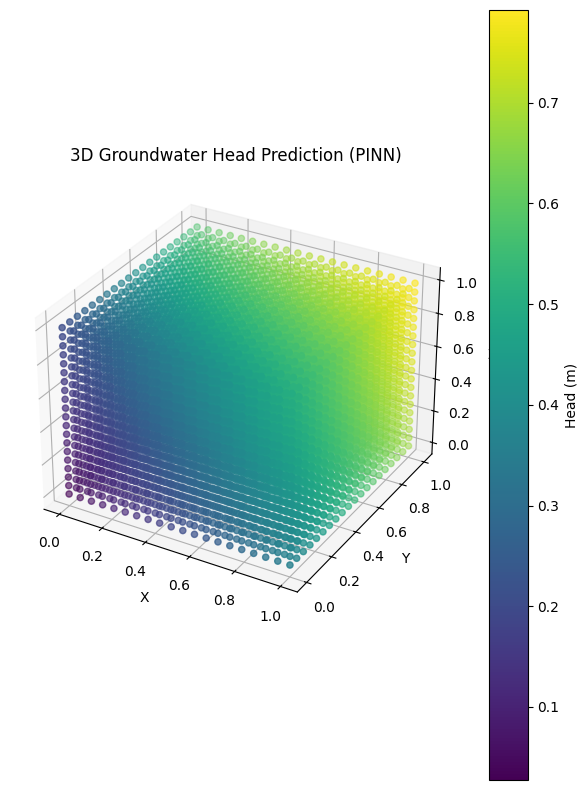

Epoch 100: Loss = 3.0636e+01


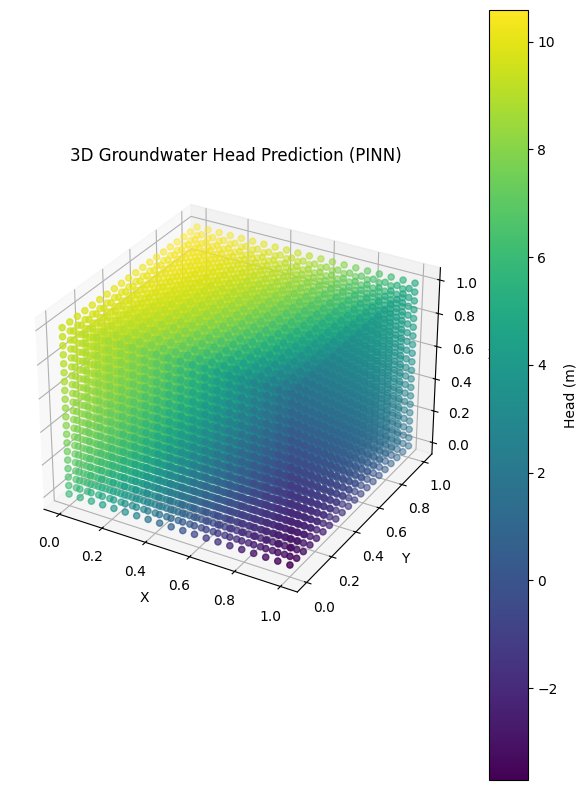

Epoch 200: Loss = 2.0155e+01


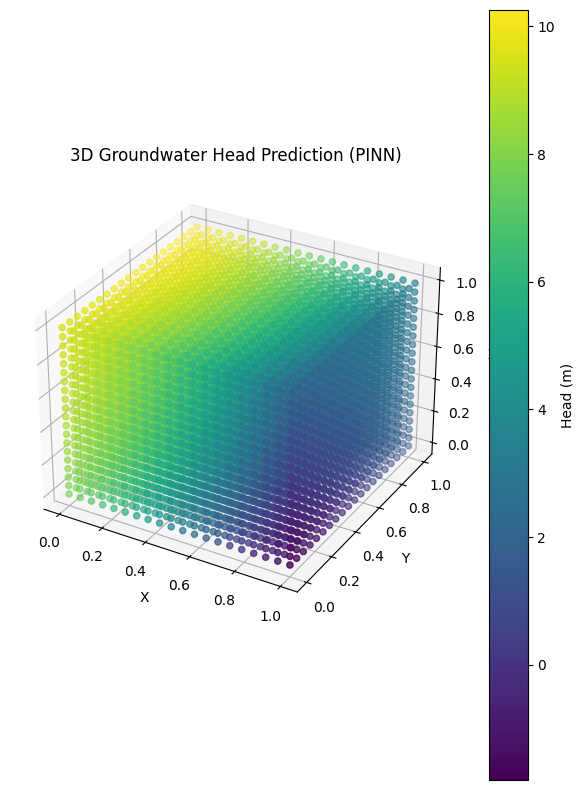

Epoch 300: Loss = 1.5770e+01


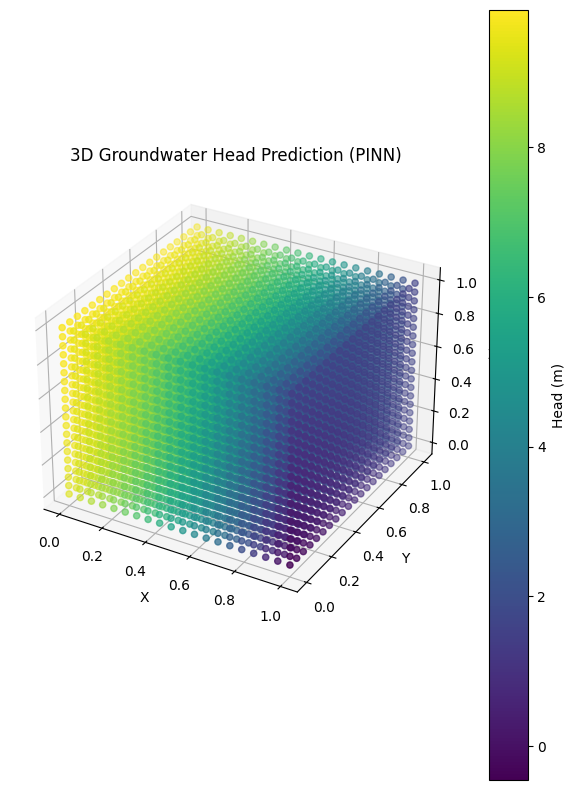

Epoch 400: Loss = 1.5333e+01


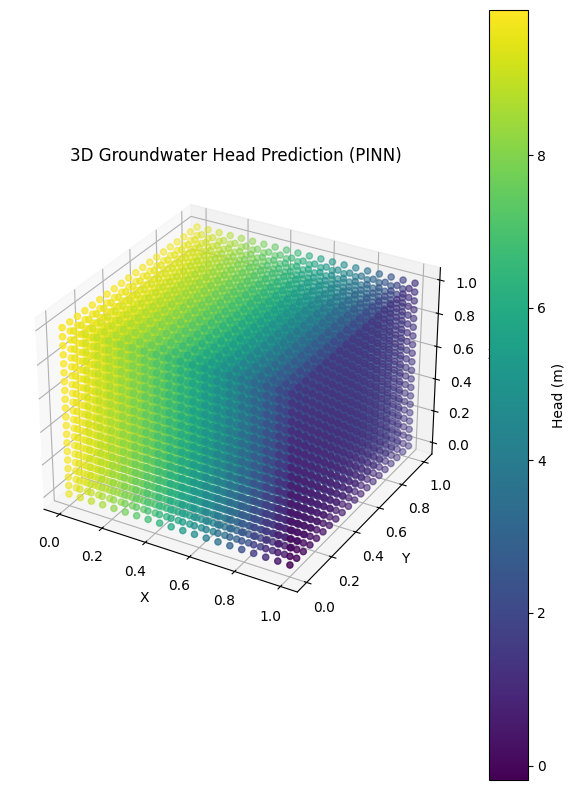

Epoch 500: Loss = 1.5237e+01


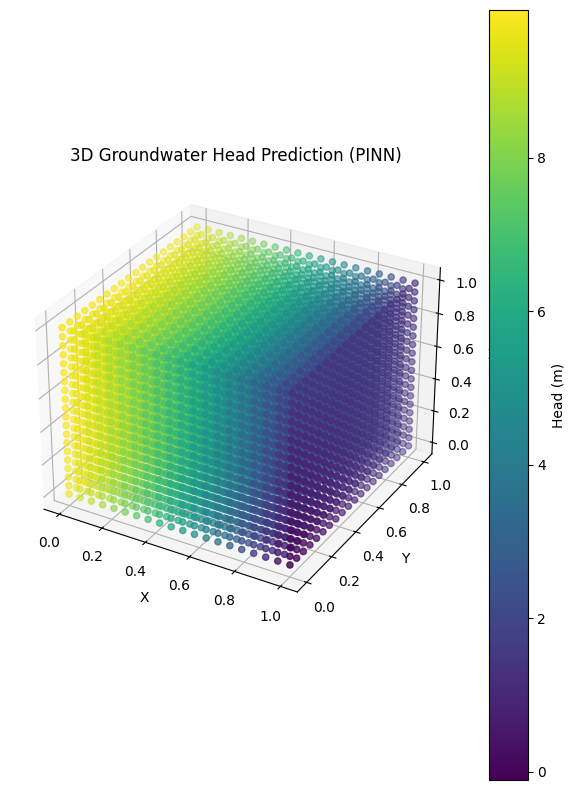


Best Model:
Best loss: 1.5237e+01 at iteration 500



In [17]:
# Training PINN
n_hl = 6  # Number of hidden layers
n_nodes = 50  # Number of nodes per layer
# lr = 5E-2  # Learning rate
epoch = 500  # Number of epochs

layers = [3, 50, 100, 50, 1]  # Neural network architecture

x_b1, y_b1, z_b1, bc_1, x_b2, y_b2, z_b2, bc_2, x_b3, y_b3, z_b3, bc_3, x_b4, y_b4, z_b4, bc_4, x_b5, y_b5, z_b5, bc_5, x_b6, y_b6, z_b6, bc_6, x_c, y_c, z_c, conds, colloc = generate_BCs_and_colloc(N_b, N_r, xmin, xmax, ymin, ymax, zmin, zmax, h1, h2, dh_dall)

# Initialize neural network
key = random.PRNGKey(1234)
params = init_mlp(layers, key)

# Initialize optimizer
# scheduler = optax.cosine_decay_schedule(init_value=1E-2, decay_steps=epoch, alpha=0.1)
scheduler = optax.cosine_decay_schedule(init_value=1E-3, decay_steps=epoch, alpha=0.05)
optimizer = optax.adam(scheduler)
opt_state = optimizer.init(params)
colloc_h_init = jax.random.uniform(random.PRNGKey(0), shape=(colloc.shape[0], 1), minval=1, maxval=10)  # 초기 압력값을 랜덤하게 설정

@jit
def update(params, opt_state, colloc, conds, colloc_h_init):
    """
    Perform one optimization step.
    """
    value, grads = jax.value_and_grad(loss_func)(params, colloc, conds, colloc_h_init)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return value, params, opt_state


# Training loop
all_losses = []
all_epochs = []
min_loss = jnp.inf
best_params = None

for i in range(epoch + 1):
    loss, params, opt_state = update(params, opt_state, colloc, conds, colloc_h_init)
    all_losses.append(loss)

    all_epochs.append(i)
    if loss < min_loss:
        min_loss = loss
        best_params = params
        best_iteration = i
    if i % 100 == 0:
        print(f"Epoch {i}: Loss = {loss:.4e}")
        # Predict head using the trained neural network
        h_pinn = neural_net(best_params, xyz_points )  # Output will be (nx*ny*nz, 1)
        h_pinn = h_pinn.reshape(nx, ny, nz)  # Reshape back to grid

        # 3D Visualization of PINN Solution
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(121, projection='3d')
        scat = ax.scatter(X, Y, Z, c=h_pinn.ravel(), cmap='viridis')
        plt.colorbar(scat, ax=ax, label='Head (m)')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Groundwater Head Prediction (PINN)')

        plt.show()

print(f"\nBest Model:")
print(f"Best loss: {min_loss:.4e} at iteration {best_iteration}\n")

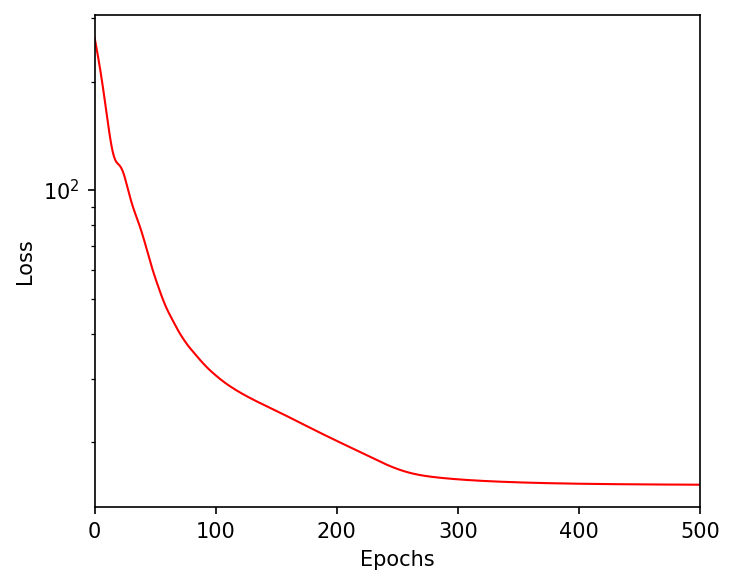

In [18]:
def plot_pinn_training(all_losses, all_epochs):
    plt.figure(figsize = (5, 4), dpi = 150)
    plt.semilogy(all_epochs, all_losses, '-r', markersize = 4, linewidth = 1.0)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.legend(prop={"size": fontsize_legend}, loc="best")
    plt.xlim(min(all_epochs), max(all_epochs))
    plt.tight_layout()

plot_pinn_training(all_losses, all_epochs)

In [19]:
# Predict head using the trained neural network
h_pinn = neural_net(best_params, xyz_points )  # Output will be (nx*ny*nz, 1)
h_pinn = h_pinn.reshape(nx, ny, nz)  # Reshape back to grid

In [20]:
import os
print(os.getcwd())

/content


In [22]:
import pickle

# ✅ Best Model 저장 함수
def save_best_model(best_params, filename="best_model.pkl"):
    """
    Save the best model parameters to a file.

    Args:
        best_params: JAX neural network parameters (list of tuples).
        filename: Name of the file to save the model.
    """
    with open(filename, "wb") as f:
        pickle.dump(best_params, f)
    print(f"✅ Best model saved to {filename}")

# ✅ Best Model 불러오기 함수
def load_best_model(filename="/content/best_model.pkl"):
    """
    Load the best model parameters from a file.

    Args:
        filename: Name of the file to load the model.

    Returns:
        best_params: Loaded JAX neural network parameters.
    """
    with open(filename, "rb") as f:
        best_params = pickle.load(f)
    print(f"✅ Best model loaded from {filename}")
    return best_params

# ✅ Best Model 저장
save_best_model(best_params)

# ✅ 저장된 모델 불러오기 (필요 시)
best_params_loaded = load_best_model()


✅ Best model saved to best_model.pkl
✅ Best model loaded from /content/best_model.pkl


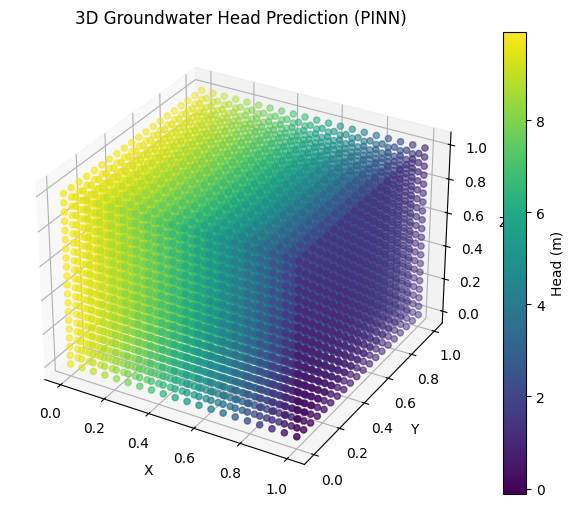

In [24]:
# 3D Visualization of PINN Solution
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=h_pinn.ravel(), cmap='viridis')
plt.colorbar(scat, ax=ax, label='Head (m)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Groundwater Head Prediction (PINN)')

plt.show()


In [25]:
# Analytical Solution Function
def analytical_solution(x, y, z, h_min=1.0, h_max=0.0, Lx=1.0, Ly=1.0, Lz=1.0):
    """
    Compute the analytical solution of 3D groundwater flow with given boundary conditions.

    Args:
        x, y, z: Arrays of spatial coordinates.

    Returns:
        h_analytical: Analytical head distribution.
    """
    return 10 - 9*x  # Linear interpolation satisfying given boundary conditions

# Generate a grid for evaluation
Nx, Ny, Nz = 20, 20, 20  # Grid resolution
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
z = np.linspace(0, 1, Nz)

# Create 3D meshgrid
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Compute Analytical Solution
H_analytical = analytical_solution(X, Y, Z)


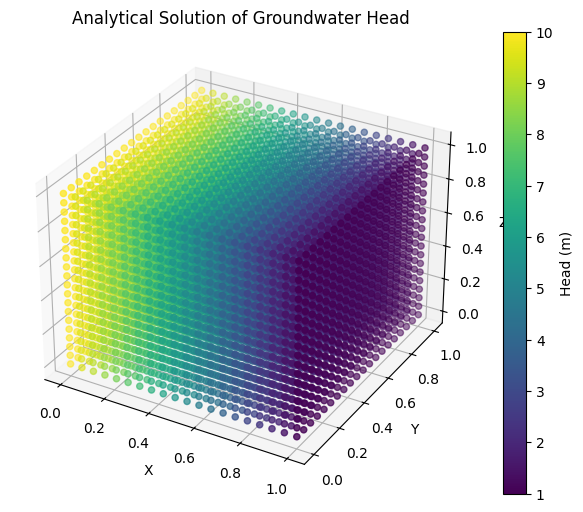

In [26]:
# Plot the Analytical Solution
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X, Y, Z, c=H_analytical.flatten(), cmap='viridis')
plt.colorbar(sc, label="Head (m)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Analytical Solution of Groundwater Head")
plt.show()

R^2 Score: 0.9820
Root Mean Squared Error (RMSE): 0.3616


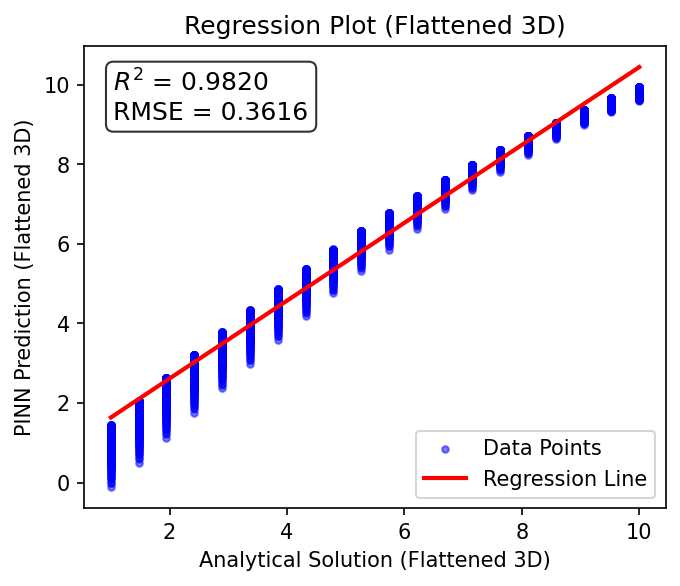

In [27]:
# Flatten the 3D arrays into 1D
H_analytical_r = H_analytical.flatten().reshape(-1, 1)  # Flatten to 1D and reshape to 2D (n_samples, n_features)
h_pinn_r = h_pinn.flatten().reshape(-1, 1)  # Flatten to 1D (n_samples, n_features)

# Perform regression
reg = LinearRegression()
reg.fit(H_analytical_r, h_pinn_r)  # Fit the model

# Predict using the regression model
y_pred = reg.predict(H_analytical_r)

# Calculate R^2 score
r2 = r2_score(h_pinn_r, y_pred)

# Calculate RMSE
mse = mean_squared_error(h_pinn_r, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print results
print(f"R^2 Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

#%% Plotting Regression for 3D Data
plt.figure(figsize=(5, 4), dpi=150)
plt.scatter(H_analytical_r, h_pinn_r, label="Data Points", color="blue", alpha=0.5, s=10)
plt.plot(H_analytical_r, y_pred, label="Regression Line", color="red", linewidth=2)

# Add annotations for RMSE and R^2
plt.text(
    0.05,
    0.95,
    f"$R^2$ = {r2:.4f}\nRMSE = {rmse:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.xlabel("Analytical Solution (Flattened 3D)")
plt.ylabel("PINN Prediction (Flattened 3D)")
plt.title("Regression Plot (Flattened 3D)")
plt.legend(loc="lower right")

plt.show()


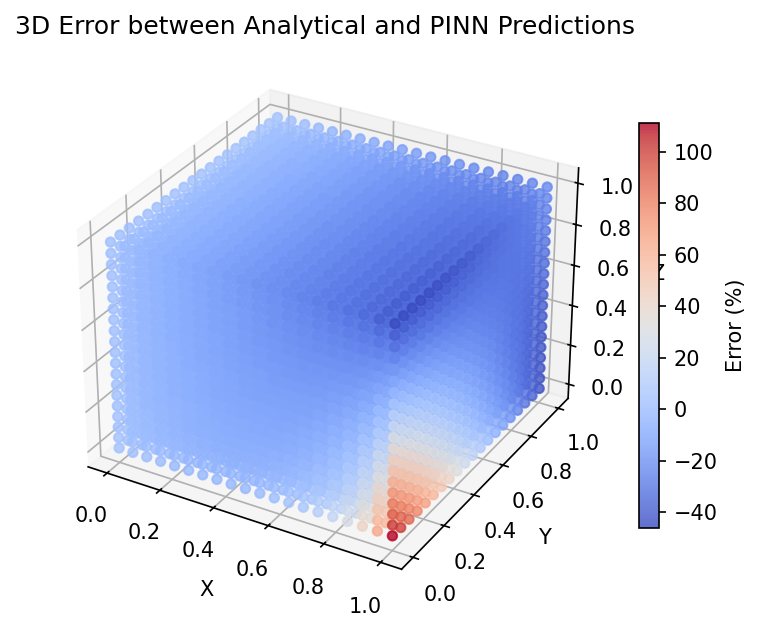

In [28]:
# Calculate percentage error
error_percentage = 100 * (H_analytical_r - h_pinn_r) / (H_analytical_r)

# Create 3D scatter plot for error visualization
fig = plt.figure(figsize=(6, 5), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of errors
sc = ax.scatter(X, Y, Z, c=error_percentage.ravel(), cmap='coolwarm', alpha=0.8)

# Color bar
cbar = plt.colorbar(sc, ax=ax, shrink=0.7, aspect=20)
cbar.set_label("Error (%)")

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Error between Analytical and PINN Predictions")

plt.show()